In [2]:
!pip install pytubefix

Elegir una funcion de manera generica

In [38]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import QasmSimulator
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

import itertools
from sympy import symbols, Eq, solve

In [39]:
# Numero de repeticiones para el montecarlo
n_MC = 1000
#numero de qubits para el circuito
n_qubits = 2

x_vals = [-2, -1, 0, 1]

#x_vals = [-3, -2, -1, 0]
#x_vals = [0, 1, 2, 3]

#x_vals = [-7, -6, -5, -4, -3, -2, -1, 0]



# 000 001 010 011 100 101 110 111
#Defino los terminos de la expresion

T4 = 3 
T3 = 0
T2 = -7
T1 = -0.5
T0 = 6



#Esta funcion me devuelve la funcion resuelta para un valor
def f(x):
    y = (-T4)*x**4 + (-T3)*x**3 + (-T2)*x**2 + (-T1)*x + (-T0)
    return y
    

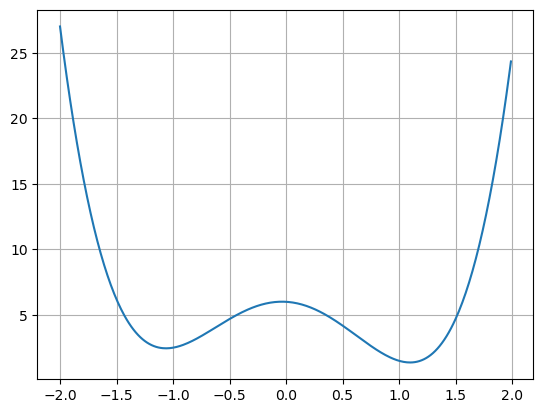

In [40]:
#Celda solo para comprobar que la funcion es la que quiero que sea
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-2.0, 2.0, 0.01)
y = T4*x**4 + T3*x**3 + T2*x**2 + T1*x + T0

plt.plot(x, y)
#plt.ylim([0,10])
plt.grid()
plt.show()

In [41]:
def qubit_states_generator(n_qubits):
    qubit_states = []
    
    if n_qubits < 6: #Cortafuegos
        #Para cada iteracion posible de los valores 01 con una longitud n_qubits se guarda en una lista
        for comb in itertools.product('01', repeat=n_qubits):
            qubit_states.append(''.join(comb))

    return qubit_states

qubit_states = qubit_states_generator(n_qubits)

In [42]:
qubit_states

['00', '01', '10', '11']

In [43]:

def Z_values_generator(qubit_states, n_qubits):
    
    Z_values = {}
    
    for i in range(len(qubit_states)):
        string = qubit_states[i]
        Z = []
        #parte no combinada de los terminos de Z
        for j in range(len(string)):
            if string[j] == '0':
                Z.append(+1)
            else:
                Z.append(-1)
                
        Z = list(reversed(Z)) #invierto la lista, recordar que los qubits se leen de derecha a izquierda

        
        ############# parte combinada de los terminos de mas a menos ################
        
        #creacion del indice para los terminos cruzados 
        #Esta parte crea la variable combination, que ira sirviendo de indice para crear los terminados cruzados
        combination = '01'
        for j in range(n_qubits-2):
            combination += str(j+2)
            #Para 3 qubits devolera 012, para 4 0123, para 5 01234 etc.


        for i in range(n_qubits-1):
        #Este bucle es para tener todas las combinaciones  de longitud 2 hasta longitud n_qubits
            
            for j in itertools.combinations(combination,i+2):
                j = list(j) #pasamos a una lista los valores de la combinacion generada por itertools
                New_Z = 1 #Se crea el valor que vamos a añadir
                #Ej: si tenemos ('012',2) nos devolvera ['0','1'], ['0','2'] y ['1','2']


                for k in range(len(j)):
                    #Para determinar el valor de ese nuevo resultado, se multiplican los valores que lo forman
                    New_Z *= Z[int(j[k])]
                    
                Z.append(New_Z)
                #finalmente se añade el nuevo resultado

        Z_values[string] = Z

    return Z_values

Z_values = Z_values_generator(qubit_states, n_qubits)

In [44]:
Z_values

{'00': [1, 1, 1], '01': [-1, 1, -1], '10': [1, -1, -1], '11': [-1, -1, 1]}

In [45]:
def solver(Z_values, qubit_states):
    symbols_list = []
    equations = []
    
    
    for i in range(len(Z_values[qubit_states[0]])+1):
        symbols_list.append(symbols(f"a{i}"))
        # creo una lista de todos los strings que van a ser las variables
        
        
    for i in range(len(symbols_list)): # i es igual a la cantidad de incognitas que voy a crear quizas se pueda cambiar por n_qubits**2
        Ecuacion = symbols_list[0] #Esto lo hago asi, por que el primer simbolo a0 va con la identidad asi que no necestio hacerle ninguna operacion
        for j in range(len(symbols_list)-1):
            Ecuacion += symbols_list[j+1]*Z_values[qubit_states[i]][j]
            #ahora añado el nuevo termino a la ecuacion
        
        print(Ecuacion) #descomentar esta linea para ver las ecuacuiones
        eq = Eq(Ecuacion, f(x_vals[i]))#genero la ecuacion de sympy, con su valor respectivo f(x)
        equations.append(eq)           #añado la ecuacion nueva
    
    #esta parte se encagra de pasar a una sola lista de floats la solucion para acceder de manera mas facil
    solution_dic = solve(equations, symbols_list)
    solution = []
    for k in range(len(solution_dic)):
        solution.append(float(solution_dic[symbols_list[k]]))
    print(solution)

    return solution

solution = solver(Z_values, qubit_states)
print(type(solution))

a0 + a1 + a2 + a3
a0 - a1 + a2 - a3
a0 + a1 - a2 - a3
a0 - a1 - a2 + a3
[-9.25, -7.25, -5.5, -5.0]
<class 'list'>


In [46]:
#funcion que quizas no haga falta, nos devuelve una lista donde cada indice indica el numero que puertas que hay para cada orden de combinaciones

def Z_lengths_iterations(n):
    Z_lenghts = []
    
    Z_lenghts.append(n)
    
    combination = '01'
    for j in range(n-2):
        combination += str(j+2)
        
    
    for i in range(n-1):      
        Z_lenghts.append(len(list(itertools.combinations(combination,i+2))))
        #print(i)


    return Z_lenghts

Z_len = Z_lengths_iterations(n_qubits)

In [47]:
Z_len

[2, 1]

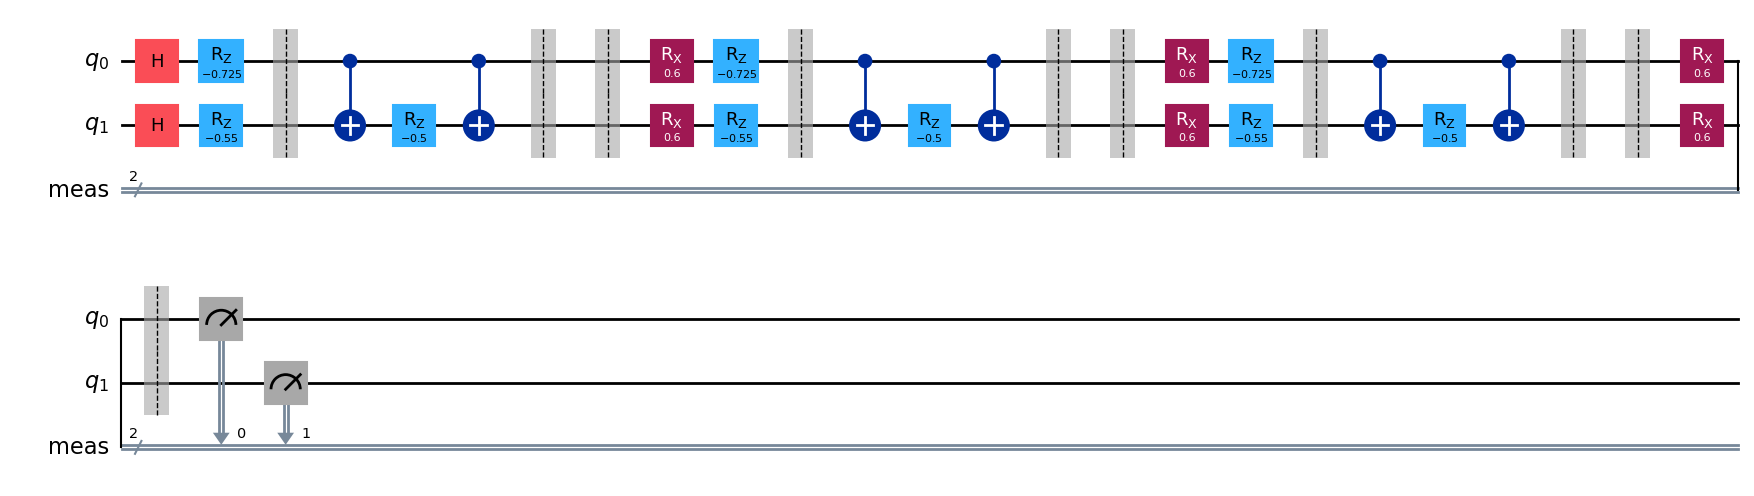

In [60]:
from qiskit.quantum_info import Statevector
gamma = 0.05
beta = 0.3
p = 3

def QAOA_circuit(n_qubits, solution, gamma, beta, p=1):    
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    #hadammard en todos

    Z_len = Z_lengths_iterations(n_qubits)
    
    for _ in range(p):
        for i in range(Z_len[0]):
            qc.rz(2 * gamma * solution[i+1],i)
        qc.barrier()
        #aplico las puertas Z a los qubits correspondientes
    
        #esta parte es simplemente para tener combination como lo tenia en la parte del Z_values_generator
        combination = '01'
        for j in range(n_qubits-2):
            combination += str(j+2)
    
        posicion_aux = n_qubits+1 #esta va a ser una variable auxiliar, simplemente para poder referirnos a los valores de solucion correctamente
        for i in range(n_qubits-1): # determino las combinaciones que tengo para esos qubits.
            lista = list(itertools.combinations(combination,i+2)) #listo las combinaciones de i puertas Z
            #print(lista) #eliminar este print para ver las combinaciones que hace
            
            #hacemos la parte de los terminos de varios Z de manera general:
            for j in range(len(lista)):
                for k in range(len(lista[0])-1):
                    qc.cx(int(lista[j][k]), int(lista[j][k+1]))
                
                qc.rz(2 * gamma * solution[posicion_aux],int(lista[j][k+1]))
                posicion_aux += 1
                for k in range(len(lista[0])-1):
                    k = len(lista[0])-2 -k # es necesario este cambio para que las rotaciones se deshagan en el orden correcto
                    qc.cx(int(lista[j][k]), int(lista[j][k+1]))
                    
                qc.barrier()
    
        qc.barrier()
    
    
        for q in range(n_qubits):
            qc.rx(2 * beta, q)
        
    qc.measure_all()
    return qc
    
qc = QAOA_circuit(n_qubits, solution, gamma, beta, p)
qc.draw('mpl')

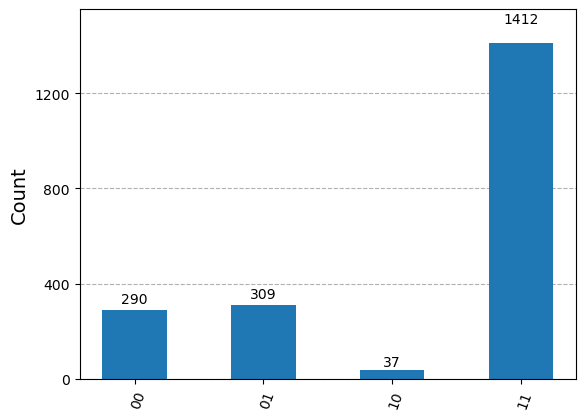

In [61]:
backend = QasmSimulator()
job = backend.run(qc, shots=2048)
counts = job.result().get_counts()

plot_histogram(counts)

In [62]:
def QAOA(n_qubits, beta, gamma, p):
    qubit_states = qubit_states_generator(n_qubits)
    #primero me creo la lista con las combinaciones de los qubits

    Z_values = Z_values_generator(qubit_states, n_qubits)
    #ahora creo un diccionario con los valores de las puertas Z para cada estado

    solution = solver(Z_values, qubit_states)
    #calculo la solucion del hamiltoniano y la guardo en una lista

    #Z_len = Z_lengths_iterations(n_qubits)
    #esta variable quiazs se pueda eliminar, ahora simplemente calulamos cuantas puertas hay para cada combinacion de de puertas

    qc_QAOA = QAOA_circuit(n_qubits, solution,gamma, beta, p) 

    backend = QasmSimulator()
    job = backend.run(qc_QAOA, shots=2048)
    counts = job.result().get_counts()

    plot_histogram(counts)

    prob_state = max(counts)
    prob_val_position = qubit_states.index(prob_state)
    prob_val = x_vals[prob_val_position]
    
    return(prob_val)

QAOA = QAOA(n_qubits, beta, gamma, p)
print(QAOA)

a0 + a1 + a2 + a3
a0 - a1 + a2 - a3
a0 + a1 - a2 - a3
a0 - a1 - a2 + a3
[-9.25, -7.25, -5.5, -5.0]
1
